Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [0]:
#!git clone https://github.com/DmitryUlyanov/deep-image-prior.git
# Citation: This codes is a replication from the Deep Image Prior paper code
'''
@article{UlyanovVL17,
    author    = {Ulyanov, Dmitry and Vedaldi, Andrea and Lempitsky, Victor},
    title     = {Deep Image Prior},
    journal   = {arXiv:1711.10925},
    year      = {2017}
}
'''

'\n@article{UlyanovVL17,\n    author    = {Ulyanov, Dmitry and Vedaldi, Andrea and Lempitsky, Victor},\n    title     = {Deep Image Prior},\n    journal   = {arXiv:1711.10925},\n    year      = {2017}\n}\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
# If run from on a separate drive directory
os.chdir('/content/drive/My Drive/Group60_Reproducibility_project_code-master')

# If run from the Deep learning reproducibility project drive directory
# os.chdir('/content/drive/My Drive/Deep learning reproducibility project/Group60_Reproducibility_project_code')

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [0]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'


## The figures of Tabel 1 Deep Image Prior paper

## Barbara
img_path  = 'Good_images/barbara.png'
mask_path = 'Good_images/noise_mask_2.png'

## Boat
# img_path  = 'Good_images/boat_512.png'
# mask_path = 'Good_images/noise_mask_1.png'

## House
# img_path  = 'Good_images/house_gray.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Lena
# img_path  = 'Good_images/lena512gray.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Peppers
# img_path  = 'Good_images/Peppers.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Cameraman
# img_path  = 'Good_images/cameraman_512.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Couple
# img_path  = 'Good_images/couple.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Finger
# img_path  = 'Good_images/fingerprint1.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Hill (goldhill)
# img_path  = 'Good_images/goldhill.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Man
# img_path  = 'Good_images/man512.png'
# mask_path = 'Good_images/noise_mask_1.png'

## Montage (Mountain*?)
# img_path  = 'Good_images/mountain512.png'
# mask_path = 'Good_images/noise_mask_1.png'

## No-flash image noise
#  img_path  = 'Good_images/No-Flash_original_corrupted.png'
#  mask_path = 'Good_images/no_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [0]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [0]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

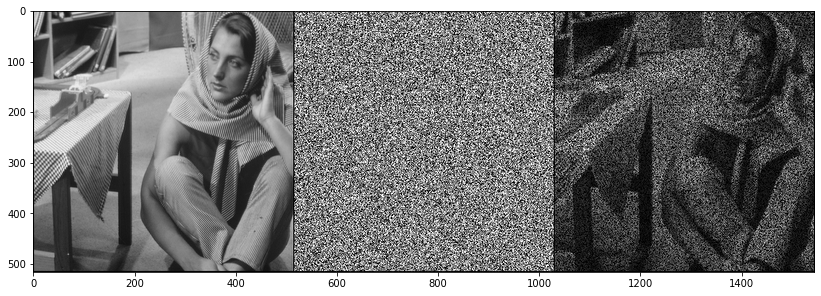

In [0]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [0]:
## SAVE Corrupted IMAGE
# from PIL import Image
# Corrupted_im = PIL.ImageChops.multiply(img_pil, img_mask_pil)
# Corrupted_im.save('Results/001')

# Setup

In [0]:
pad = 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [0]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.04
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path) or ('Good_images' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32 # vary from 2 to 200, original 32
    LR = 0.01 
    num_iter = 6001 # vary from 101 to 10001, original 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.0 #vary from 0 to 0.20, original 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 6001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.15
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [0]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002369


# Main loop

Starting optimization with ADAM


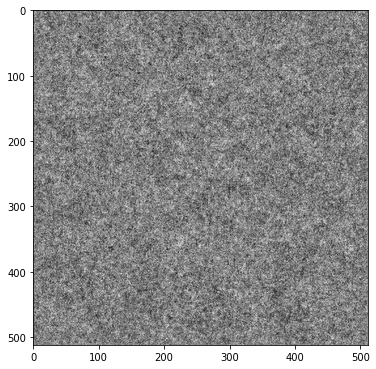

KeyboardInterrupt: ignored

In [0]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
   
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

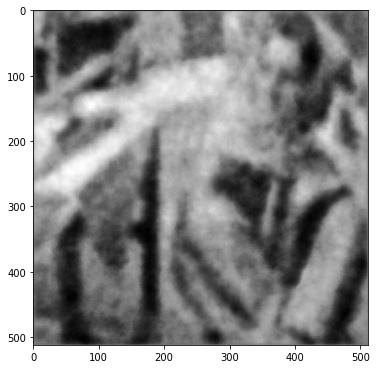

In [0]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [0]:
## SAVE IMAGE
# from torchvision.utils import save_image
# A = net(net_input)[0]
# save_image(A, 'Results/001')

#from PIL import Image
## TEST with noise
#A = np.ones((512,512))*255*np.random.rand(512,512);
## TEST END
#im = Image.fromarray(np.uint8(A))
#im = Image.fromarray(A)
#im = im.convert("L")
#im.save('Results/Barbara.png',"png")


In [0]:
# Image path of to be compared images (PSNR)
import math
import cv2

# Boat
# original_path = 'Good_images/boat_512.png'
# corrupted_path = 'Results/Boat_corrupted.png'
# restored_path = 'Results/Boat_restored.png'

# Peppers
original_path = 'Good_images/Peppers.png'
corrupted_path = 'Results/Peppers_corrupted.png'
restored_path = 'Results/Peppers_restored.png'

In [0]:
# Load Image to compute psnr
original = cv2.imread(original_path)
corrupted = cv2.imread(corrupted_path)
restored = cv2.imread(restored_path)

In [0]:
# Compute PSNR
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return "Same Image"
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(restored,original)
print('The Peak Signal to Noise Ratio is: %f' % (d))

The Peak Signal to Noise Ratio is: 36.022828


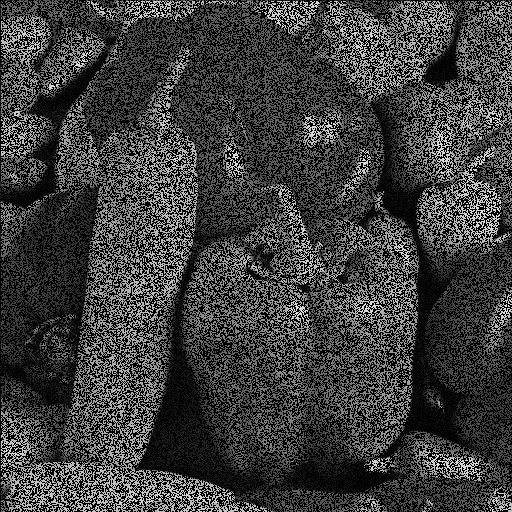

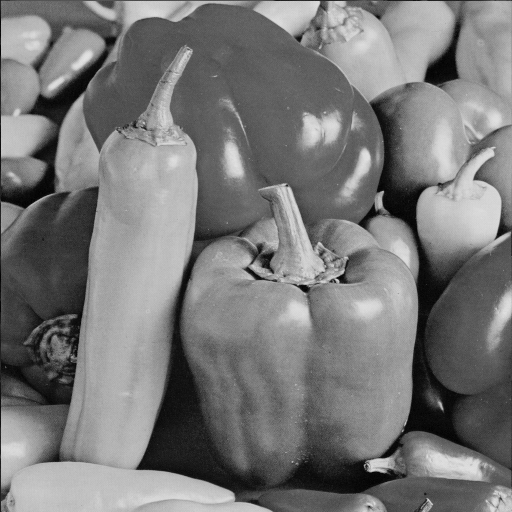

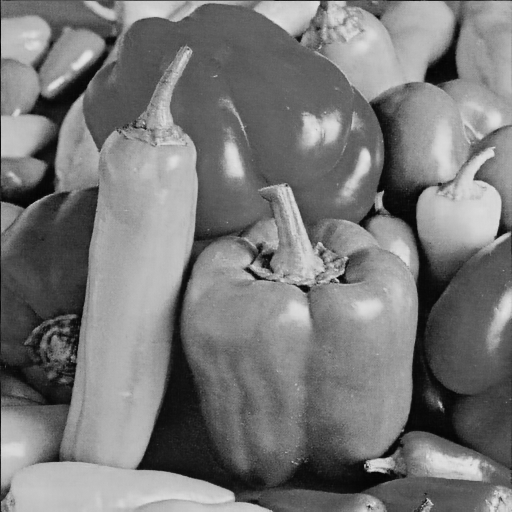

-1

In [0]:
# Show Images
from google.colab.patches import cv2_imshow
# Corrupt 
cv2_imshow(corrupted)
cv2.waitKey(0)
# Original
cv2_imshow(original)
cv2.waitKey(0)
# Restored
cv2_imshow(restored)
cv2.waitKey(0)